### Data Preprocessing

In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import json
from time import sleep
from tqdm import tqdm


from helpers.facedetection import extractFaces
from helpers.UTKFaceDataprocessing import UTKFaceProcessing, UTKFaceTrainTestSplit, UTKFaceDataDistribution
from models.AgeGenderModel import AGmodel

In [7]:
fldr = "./UTKFace_10k"
images, labels, ages, genders, images_o = UTKFaceProcessing(fldr)

Importing labels: 100%|█████████████████████████████████████| 9780/9780 [00:00<00:00, 489023.78it/s]


In [112]:
X_train, X_test, Y_train, Y_test= UTKFaceTrainTestSplit(images, labels, testSize=0.25)
Y_train_2=[Y_train[:,1],Y_train[:,0]]
Y_test_2=[Y_test[:,1],Y_test[:,0]]

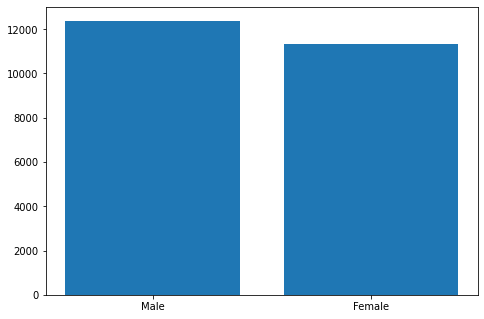

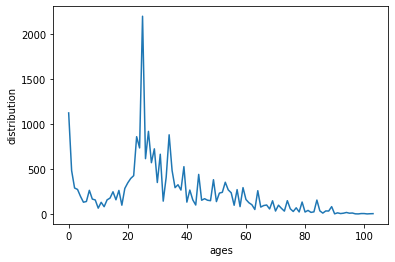

In [74]:
UTKFaceDataDistribution(genders, ages)

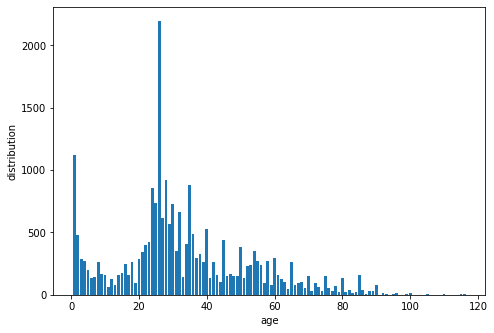

In [79]:
age_val, age_count = np.unique(ages, return_counts=True)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(age_val, age_count)
plt.xlabel('age')
plt.ylabel('distribution')
plt.show()

In [78]:
age_count

array([1123,  482,  289,  273,  196,  131,  139,  263,  166,  156,   65,
        130,   81,  157,  177,  247,  158,  262,   98,  284,  346,  395,
        426,  859,  734, 2197,  615,  918,  570,  724,  350,  664,  143,
        409,  880,  483,  293,  325,  266,  526,  132,  266,  157,  100,
        440,  153,  170,  153,  148,  381,  138,  232,  241,  353,  268,
        236,   97,  271,   82,  293,  161,  125,  103,   50,  259,   77,
         94,  100,   56,  147,   33,   98,   63,   32,  148,   58,   28,
         69,   23,  133,   22,   40,   18,   24,  155,   35,   10,   34,
         33,   82,    2,   13,    5,    9,   17,    9,   11,    2,    1,
          5,    5,    1,    3,    4], dtype=int64)

### Model

In [3]:
Model=AGmodel((48,48,3))

In [4]:
Model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 48, 48, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 48, 48, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 48, 48, 32)   0           dropout[0][0]                    
______________________________________________________________________________________________

### Training

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [12]:
fle_s='./saved/Age_sex_detection_UTKFace10k.h5'
checkpointer = ModelCheckpoint(fle_s, monitor='val_loss',verbose=1,save_best_only=True,save_weights_only=False, mode='auto',save_freq='epoch')
Early_stop = EarlyStopping(patience=75, monitor='val_loss',restore_best_weights=True),
callback_list = [checkpointer,Early_stop]

In [83]:
History=Model.fit(X_train,Y_train_2,batch_size=64,validation_data=(X_test,Y_test_2),epochs=250,callbacks=[callback_list])

Epoch 1/250
115/115 [==============================] - 61s 522ms/step - loss: 23.1763 - sex_out_loss: 0.7274 - age_out_loss: 22.2089 - sex_out_accuracy: 0.5278 - age_out_accuracy: 0.1088 - val_loss: 20.8687 - val_sex_out_loss: 0.6864 - val_age_out_loss: 20.0066 - val_sex_out_accuracy: 0.5595 - val_age_out_accuracy: 0.1088

Epoch 00001: val_loss improved from inf to 20.86873, saving model to ./saved\Age_sex_detection_UTKFace10k.h5
Epoch 2/250
115/115 [==============================] - 61s 528ms/step - loss: 20.0576 - sex_out_loss: 0.6867 - age_out_loss: 19.1940 - sex_out_accuracy: 0.5524 - age_out_accuracy: 0.1127 - val_loss: 17.4690 - val_sex_out_loss: 0.6823 - val_age_out_loss: 16.5773 - val_sex_out_accuracy: 0.5595 - val_age_out_accuracy: 0.1039

Epoch 00002: val_loss improved from 20.86873 to 17.46897, saving model to ./saved\Age_sex_detection_UTKFace10k.h5
Epoch 3/250
115/115 [==============================] - 60s 525ms/step - loss: 15.1558 - sex_out_loss: 0.6671 - age_out_loss: 14

### Saving model and data

In [ ]:
# Save path
save_dr = './saved/'
# Get the dictionary containing each metric and the loss for each epoch
history_dict = History.history
# Save it under the form of a json file
json.dump(history_dict, open(save_dr+'UTKFace23k_history.json', 'w'))

### Loadingn model and data

In [3]:
Model = tf.keras.models.load_model('./saved/Age_sex_detection_UTKFace23k.h5')
History = json.load(open('./saved/UTKFace23k_history.json', 'r'))

### Evaluate model

In [116]:
Model.evaluate(X_test,Y_test_2)

186/186 [==============================] - 11s 58ms/step - loss: 6.0896 - sex_out_loss: 0.1807 - age_out_loss: 5.0813 - sex_out_sex_out_accuracy: 0.9217 - age_out_age_out_accuracy: 0.0462


[6.089611053466797,
 0.18072949349880219,
 5.0813117027282715,
 0.921714186668396,
 0.04622912034392357]

In [117]:
pred=Model.predict(X_test)

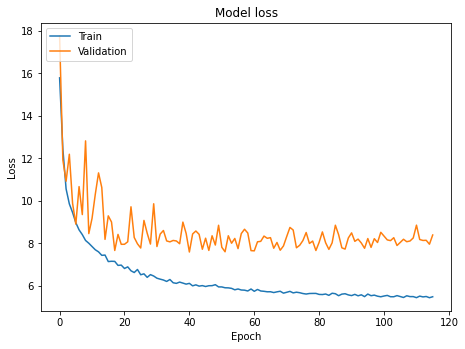

In [118]:
plt.plot(History['loss'])
plt.plot(History['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25, wspace=0.35)       

### For gender

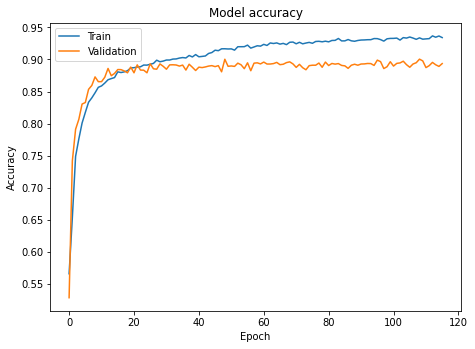

In [119]:
plt.plot(History['sex_out_accuracy'])
plt.plot(History['val_sex_out_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)

### For age

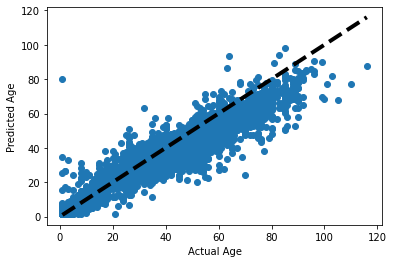

In [120]:
fig, ax = plt.subplots()
ax.scatter(Y_test_2[1], pred[1])
ax.plot([Y_test_2[1].min(),Y_test_2[1].max()], [Y_test_2[1].min(), Y_test_2[1].max()], 'k--', lw=4)
ax.set_xlabel('Actual Age')
ax.set_ylabel('Predicted Age')
plt.show()

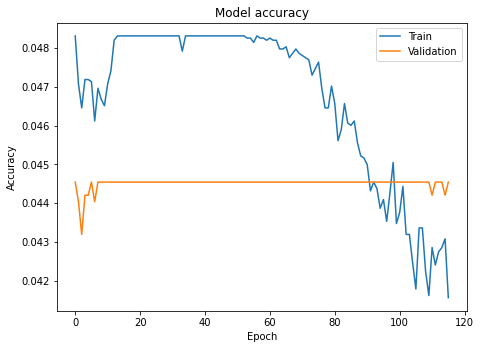

In [522]:
plt.plot(History['age_out_accuracy'])
plt.plot(History['val_age_out_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25, wspace=0.35)

### For gender

In [121]:
i=0
Pred_l=[]
while(i<len(pred[0])):

  Pred_l.append(int(np.round(pred[0][i])))
  i+=1

In [33]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report

In [122]:
report=classification_report(Y_test_2[0], Pred_l, target_names=['Male', 'Female'])

In [35]:
print(report)

              precision    recall  f1-score   support

        Male       0.88      0.81      0.85      1091
      Female       0.86      0.91      0.88      1354

    accuracy                           0.87      2445
   macro avg       0.87      0.86      0.86      2445
weighted avg       0.87      0.87      0.87      2445



In [123]:
results = confusion_matrix(Y_test_2[0], Pred_l)

<AxesSubplot:>

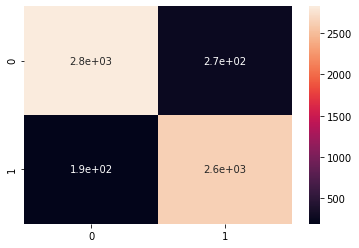

In [124]:
import seaborn as sns
sns.heatmap(results, annot=True)

### For age

In [125]:
i=0
Pred_2=[]
while(i<len(pred[1])):
    Pred_2.append(int(np.round(pred[1][i])))
    i+=1

In [127]:
report=classification_report(Y_test_2[1], Pred_2)
print(report)

              precision    recall  f1-score   support

           1       0.70      0.80      0.75       274
           2       0.31      0.33      0.32       120
           3       0.17      0.16      0.16        77
           4       0.28      0.19      0.23        72
           5       0.12      0.15      0.13        40
           6       0.05      0.06      0.05        34
           7       0.12      0.21      0.16        29
           8       0.16      0.09      0.11        68
           9       0.17      0.16      0.17        50
          10       0.11      0.11      0.11        37
          11       0.00      0.00      0.00        16
          12       0.00      0.00      0.00        19
          13       0.00      0.00      0.00        24
          14       0.17      0.07      0.10        44
          15       0.00      0.00      0.00        43
          16       0.09      0.04      0.06        48
          17       0.03      0.03      0.03        32
          18       0.09    

C:\Users\cpang\miniconda3\envs\nnlm\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cpang\miniconda3\envs\nnlm\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cpang\miniconda3\envs\nnlm\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cpang\miniconda3\envs

In [4]:
def test_image(index,images, genders, ages ,Model, showImg=False, withLabel=False, withReturn=False):
    ages_f = np.array(ages)
    genders_f = np.array(genders)
    
    if showImg:
        plt.imshow(images_o[index])
        plt.show()
        plt.clf()
    
    image_test= np.array(images[index])/255
    pred_1=Model.predict(np.array([image_test]))

    sex_f=['Male','Female']
    age=int(np.round(pred_1[1][0]))
    sex=int(np.round(pred_1[0][0]))
    
    if withLabel:
        print(f"Predicted Age: {str(age)}, Actual age: {str(ages_f[index])}")
        print(f"Predicted Sex: {sex_f[sex]}, Actual sex: {sex_f[genders_f[index]]}")
    else:
        print(f"Predicted Age: {str(age)}")
        print(f"Predicted Sex: {sex_f[sex]}")
        
    if withReturn:
        return age, ages_f[index], sex, genders_f[index]

### Testing
Testing random images with error bound for correctness -5 and +5 years for age.

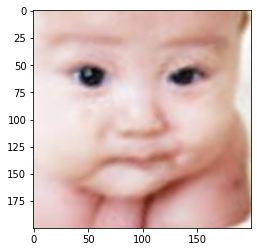

Predicted Age: 1, Actual age: 1
Predicted Sex: Female, Actual sex: Male


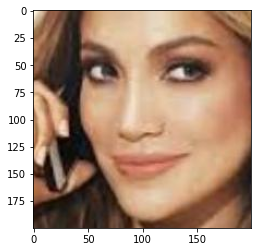

Predicted Age: 27, Actual age: 26
Predicted Sex: Female, Actual sex: Female


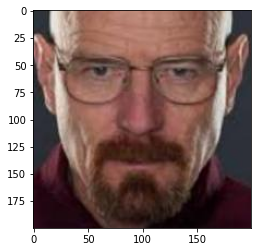

Predicted Age: 49, Actual age: 58
Predicted Sex: Male, Actual sex: Male


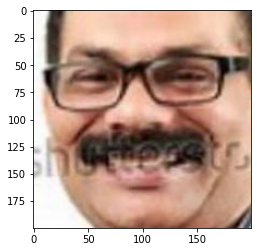

Predicted Age: 47, Actual age: 49
Predicted Sex: Male, Actual sex: Male


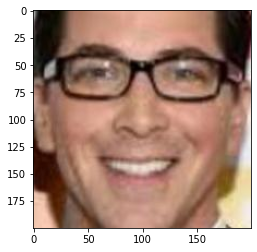

Predicted Age: 28, Actual age: 28
Predicted Sex: Male, Actual sex: Male


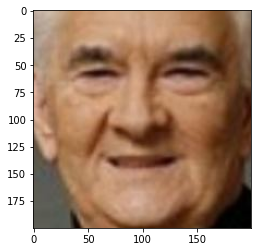

Predicted Age: 64, Actual age: 75
Predicted Sex: Male, Actual sex: Male


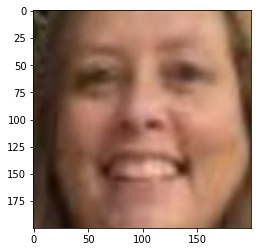

Predicted Age: 34, Actual age: 31
Predicted Sex: Female, Actual sex: Female


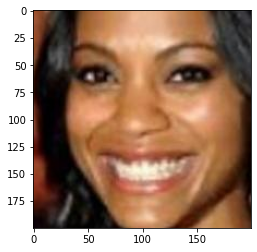

Predicted Age: 26, Actual age: 28
Predicted Sex: Female, Actual sex: Female


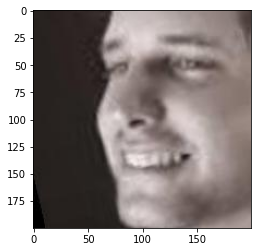

Predicted Age: 31, Actual age: 26
Predicted Sex: Male, Actual sex: Male


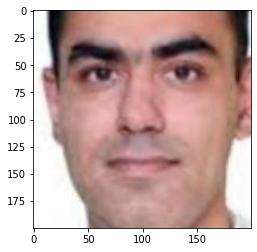

Predicted Age: 27, Actual age: 36
Predicted Sex: Male, Actual sex: Male


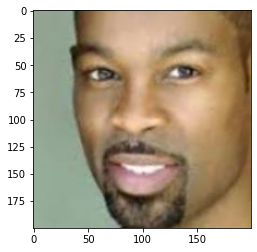

Predicted Age: 28, Actual age: 29
Predicted Sex: Male, Actual sex: Male


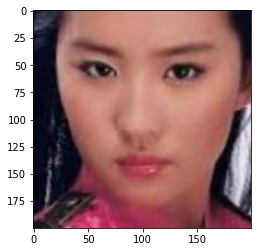

Predicted Age: 24, Actual age: 23
Predicted Sex: Female, Actual sex: Female


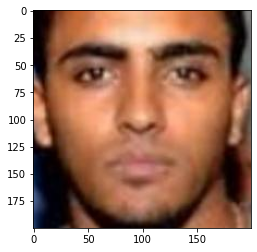

Predicted Age: 21, Actual age: 24
Predicted Sex: Male, Actual sex: Male


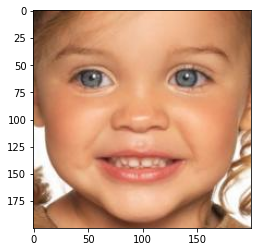

Predicted Age: 4, Actual age: 5
Predicted Sex: Female, Actual sex: Female


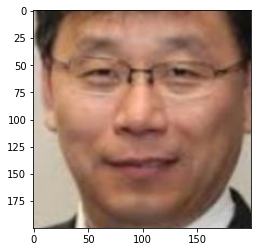

Predicted Age: 45, Actual age: 42
Predicted Sex: Male, Actual sex: Male


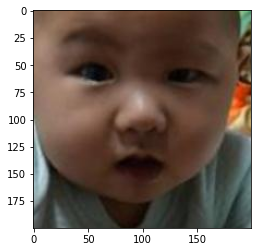

Predicted Age: 2, Actual age: 1
Predicted Sex: Male, Actual sex: Male


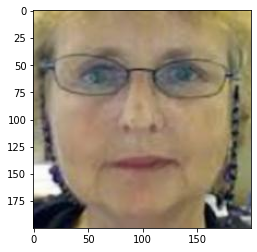

Predicted Age: 47, Actual age: 55
Predicted Sex: Female, Actual sex: Female


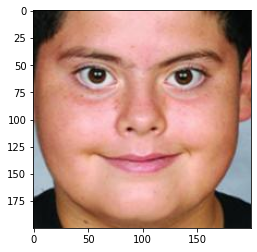

Predicted Age: 21, Actual age: 14
Predicted Sex: Male, Actual sex: Male


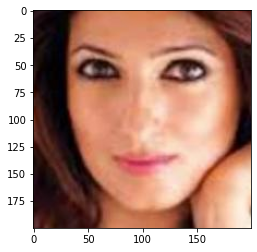

Predicted Age: 27, Actual age: 26
Predicted Sex: Female, Actual sex: Female


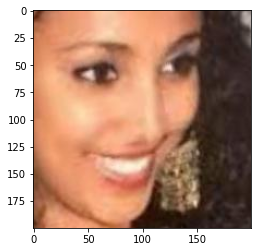

Predicted Age: 25, Actual age: 26
Predicted Sex: Female, Actual sex: Female


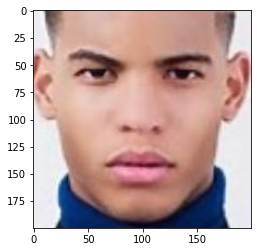

Predicted Age: 22, Actual age: 22
Predicted Sex: Male, Actual sex: Male


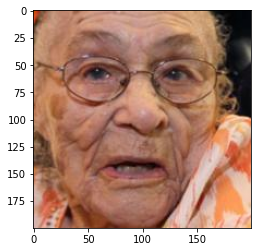

Predicted Age: 87, Actual age: 116
Predicted Sex: Female, Actual sex: Female


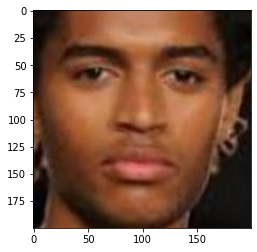

Predicted Age: 21, Actual age: 20
Predicted Sex: Male, Actual sex: Male


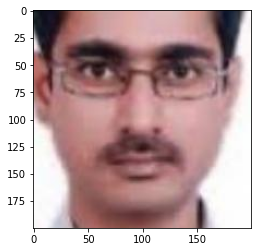

Predicted Age: 28, Actual age: 27
Predicted Sex: Male, Actual sex: Male


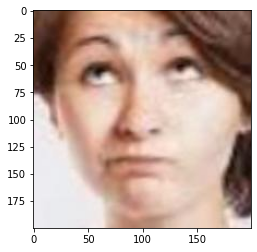

Predicted Age: 30, Actual age: 26
Predicted Sex: Female, Actual sex: Female


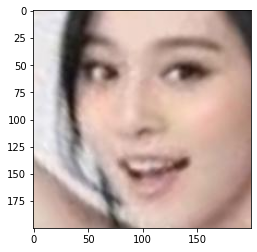

Predicted Age: 25, Actual age: 26
Predicted Sex: Female, Actual sex: Female


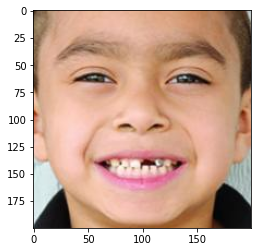

Predicted Age: 6, Actual age: 10
Predicted Sex: Male, Actual sex: Male


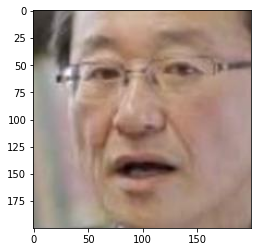

Predicted Age: 52, Actual age: 60
Predicted Sex: Male, Actual sex: Male


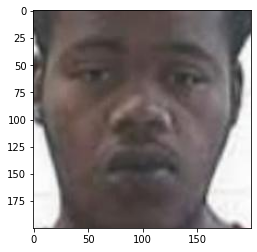

Predicted Age: 28, Actual age: 25
Predicted Sex: Male, Actual sex: Male


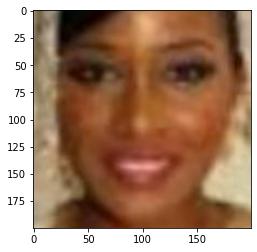

Predicted Age: 34, Actual age: 33
Predicted Sex: Female, Actual sex: Female


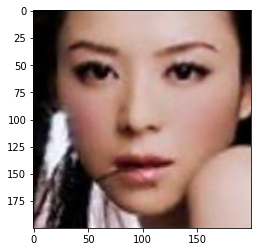

Predicted Age: 21, Actual age: 24
Predicted Sex: Female, Actual sex: Female


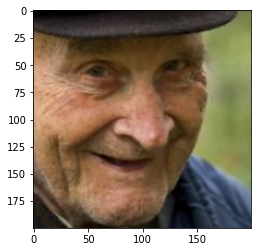

Predicted Age: 71, Actual age: 90
Predicted Sex: Male, Actual sex: Male


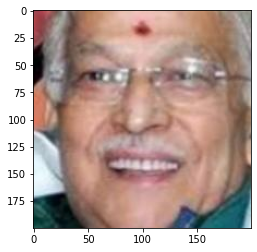

Predicted Age: 76, Actual age: 54
Predicted Sex: Male, Actual sex: Male


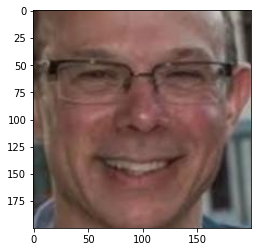

Predicted Age: 50, Actual age: 52
Predicted Sex: Male, Actual sex: Male


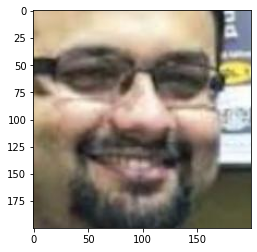

Predicted Age: 30, Actual age: 30
Predicted Sex: Male, Actual sex: Male


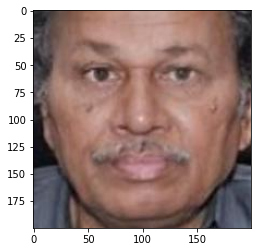

Predicted Age: 41, Actual age: 54
Predicted Sex: Male, Actual sex: Male


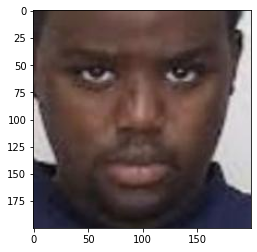

Predicted Age: 18, Actual age: 15
Predicted Sex: Male, Actual sex: Male


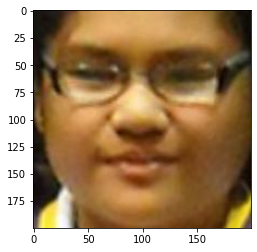

Predicted Age: 25, Actual age: 14
Predicted Sex: Female, Actual sex: Female


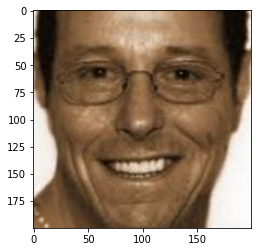

Predicted Age: 40, Actual age: 43
Predicted Sex: Male, Actual sex: Male


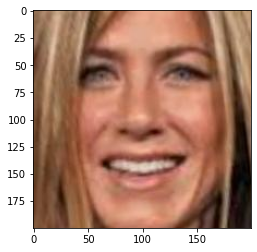

Predicted Age: 31, Actual age: 32
Predicted Sex: Female, Actual sex: Female


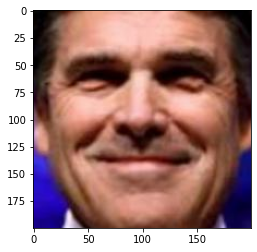

Predicted Age: 42, Actual age: 51
Predicted Sex: Male, Actual sex: Male


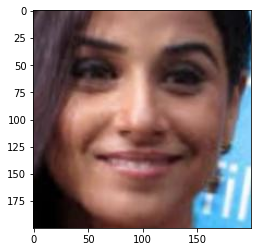

Predicted Age: 27, Actual age: 29
Predicted Sex: Female, Actual sex: Female


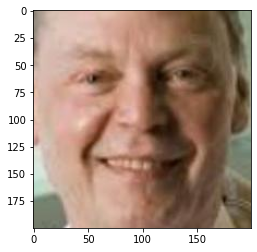

Predicted Age: 57, Actual age: 57
Predicted Sex: Male, Actual sex: Male


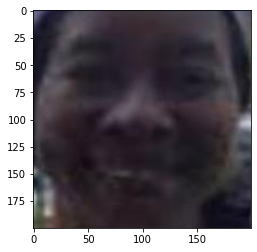

Predicted Age: 25, Actual age: 38
Predicted Sex: Male, Actual sex: Male


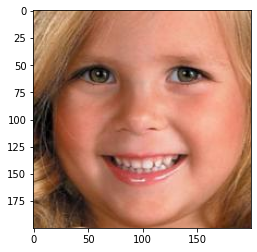

Predicted Age: 4, Actual age: 4
Predicted Sex: Female, Actual sex: Female


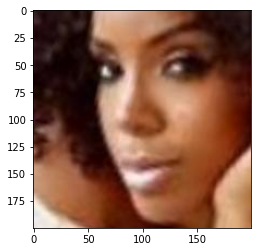

Predicted Age: 22, Actual age: 26
Predicted Sex: Female, Actual sex: Female


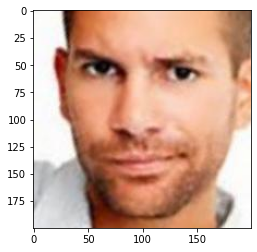

Predicted Age: 26, Actual age: 25
Predicted Sex: Male, Actual sex: Male


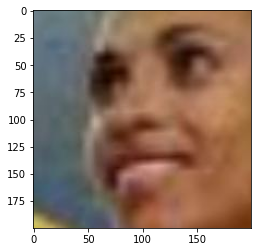

Predicted Age: 31, Actual age: 25
Predicted Sex: Male, Actual sex: Male


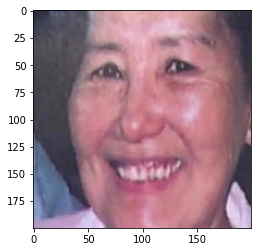

Predicted Age: 63, Actual age: 70
Predicted Sex: Female, Actual sex: Female


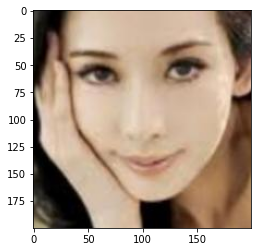

Predicted Age: 25, Actual age: 26
Predicted Sex: Female, Actual sex: Female


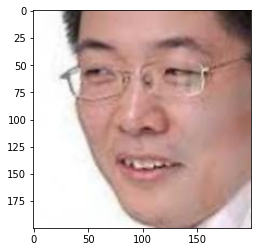

Predicted Age: 43, Actual age: 42
Predicted Sex: Male, Actual sex: Male


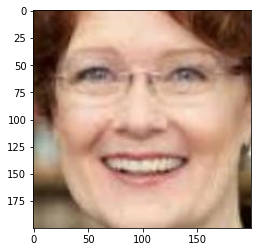

Predicted Age: 46, Actual age: 45
Predicted Sex: Female, Actual sex: Female


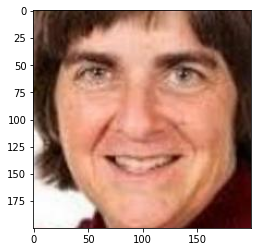

Predicted Age: 55, Actual age: 56
Predicted Sex: Female, Actual sex: Female


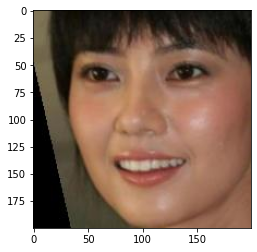

Predicted Age: 21, Actual age: 28
Predicted Sex: Female, Actual sex: Female


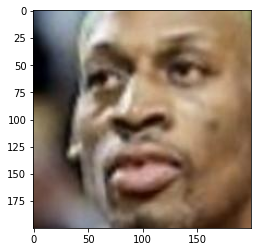

Predicted Age: 31, Actual age: 29
Predicted Sex: Male, Actual sex: Male


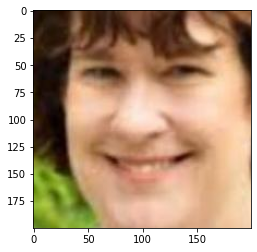

Predicted Age: 37, Actual age: 39
Predicted Sex: Female, Actual sex: Female


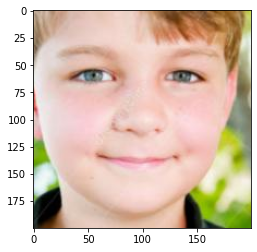

Predicted Age: 7, Actual age: 8
Predicted Sex: Male, Actual sex: Male


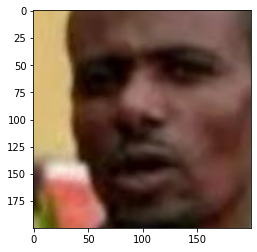

Predicted Age: 28, Actual age: 32
Predicted Sex: Male, Actual sex: Male


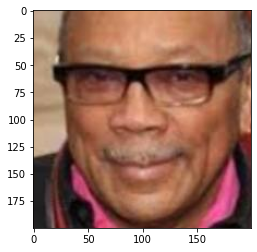

Predicted Age: 55, Actual age: 58
Predicted Sex: Male, Actual sex: Male


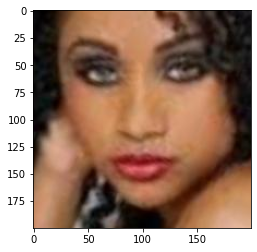

Predicted Age: 24, Actual age: 32
Predicted Sex: Female, Actual sex: Female


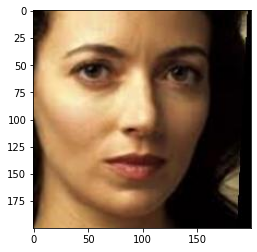

Predicted Age: 26, Actual age: 28
Predicted Sex: Female, Actual sex: Female


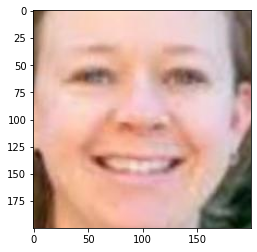

Predicted Age: 36, Actual age: 36
Predicted Sex: Female, Actual sex: Female


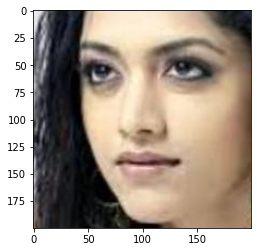

Predicted Age: 22, Actual age: 27
Predicted Sex: Female, Actual sex: Female


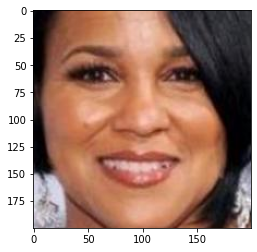

Predicted Age: 43, Actual age: 48
Predicted Sex: Female, Actual sex: Female


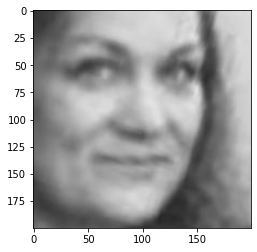

Predicted Age: 37, Actual age: 53
Predicted Sex: Female, Actual sex: Female


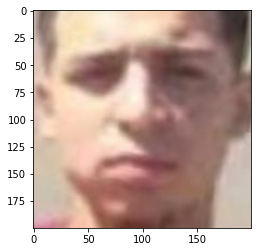

Predicted Age: 29, Actual age: 26
Predicted Sex: Male, Actual sex: Male


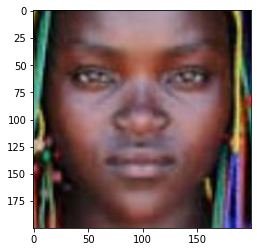

Predicted Age: 20, Actual age: 26
Predicted Sex: Female, Actual sex: Female


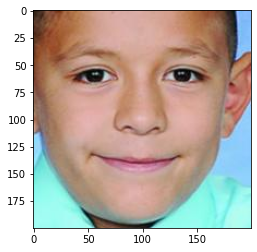

Predicted Age: 8, Actual age: 8
Predicted Sex: Male, Actual sex: Male


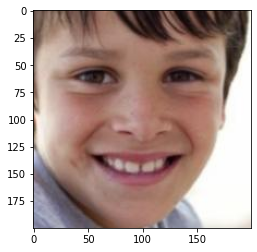

Predicted Age: 8, Actual age: 8
Predicted Sex: Male, Actual sex: Male


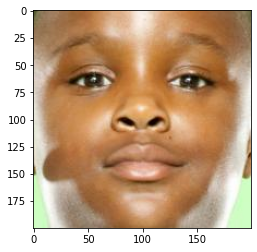

Predicted Age: 11, Actual age: 9
Predicted Sex: Female, Actual sex: Male


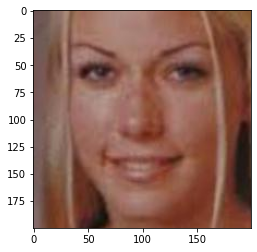

Predicted Age: 27, Actual age: 27
Predicted Sex: Female, Actual sex: Female


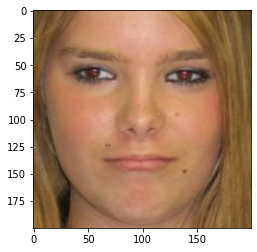

Predicted Age: 9, Actual age: 18
Predicted Sex: Female, Actual sex: Female


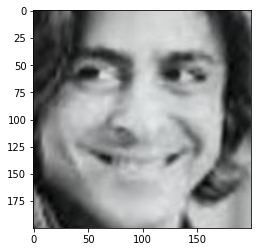

Predicted Age: 22, Actual age: 33
Predicted Sex: Female, Actual sex: Male


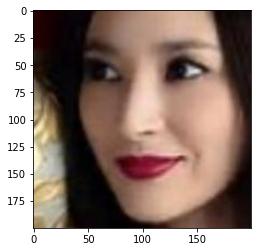

Predicted Age: 20, Actual age: 26
Predicted Sex: Female, Actual sex: Female


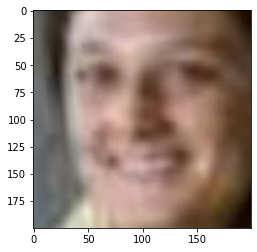

Predicted Age: 33, Actual age: 54
Predicted Sex: Male, Actual sex: Female


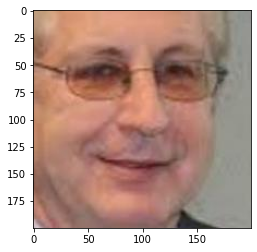

Predicted Age: 52, Actual age: 58
Predicted Sex: Male, Actual sex: Male


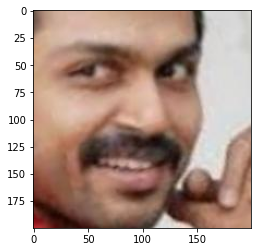

Predicted Age: 24, Actual age: 26
Predicted Sex: Male, Actual sex: Male


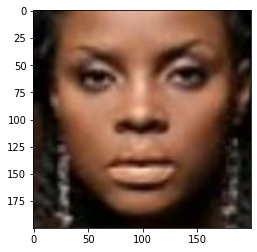

Predicted Age: 27, Actual age: 25
Predicted Sex: Female, Actual sex: Female


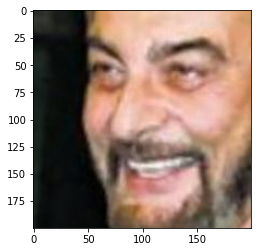

Predicted Age: 46, Actual age: 55
Predicted Sex: Male, Actual sex: Male


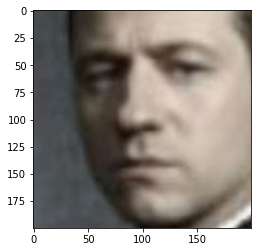

Predicted Age: 31, Actual age: 35
Predicted Sex: Male, Actual sex: Male


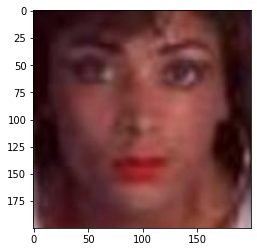

Predicted Age: 33, Actual age: 38
Predicted Sex: Female, Actual sex: Female


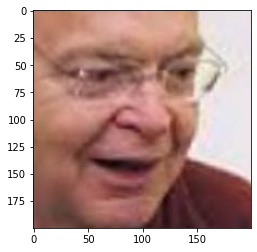

Predicted Age: 57, Actual age: 67
Predicted Sex: Male, Actual sex: Male


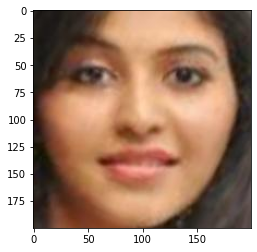

Predicted Age: 24, Actual age: 25
Predicted Sex: Female, Actual sex: Female


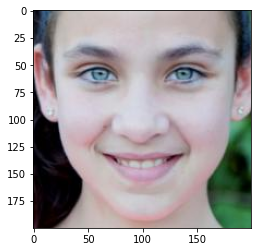

Predicted Age: 13, Actual age: 13
Predicted Sex: Female, Actual sex: Female


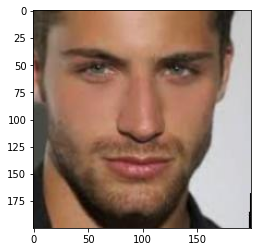

Predicted Age: 24, Actual age: 26
Predicted Sex: Male, Actual sex: Male


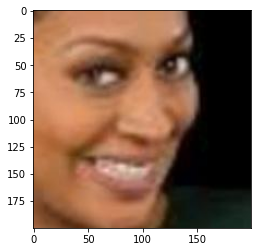

Predicted Age: 24, Actual age: 26
Predicted Sex: Female, Actual sex: Female


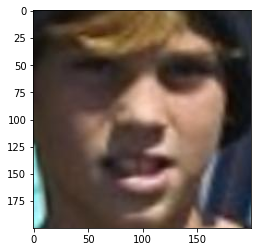

Predicted Age: 16, Actual age: 15
Predicted Sex: Male, Actual sex: Male


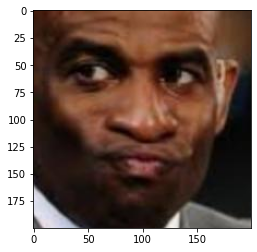

Predicted Age: 27, Actual age: 35
Predicted Sex: Male, Actual sex: Male


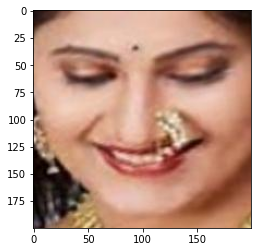

Predicted Age: 31, Actual age: 35
Predicted Sex: Female, Actual sex: Female


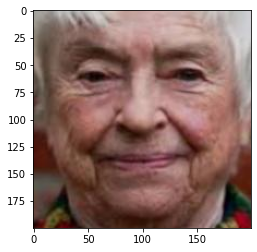

Predicted Age: 67, Actual age: 73
Predicted Sex: Female, Actual sex: Female


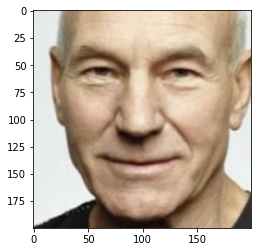

Predicted Age: 56, Actual age: 70
Predicted Sex: Male, Actual sex: Male


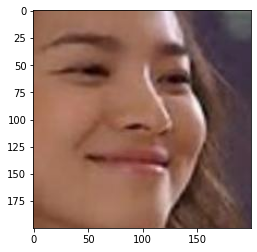

Predicted Age: 21, Actual age: 24
Predicted Sex: Female, Actual sex: Female


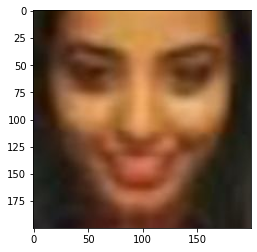

Predicted Age: 26, Actual age: 28
Predicted Sex: Female, Actual sex: Female


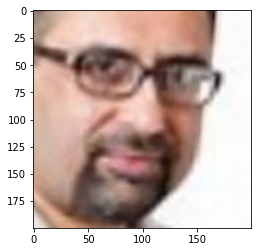

Predicted Age: 41, Actual age: 38
Predicted Sex: Male, Actual sex: Male


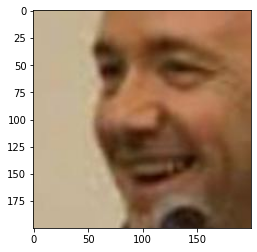

Predicted Age: 38, Actual age: 48
Predicted Sex: Male, Actual sex: Male


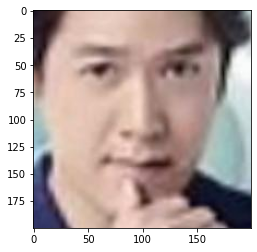

Predicted Age: 23, Actual age: 26
Predicted Sex: Male, Actual sex: Male


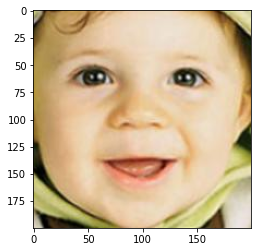

Predicted Age: 1, Actual age: 1
Predicted Sex: Female, Actual sex: Male


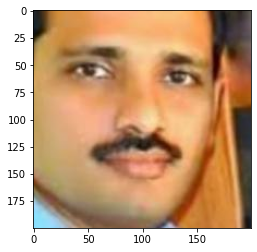

Predicted Age: 30, Actual age: 23
Predicted Sex: Male, Actual sex: Male


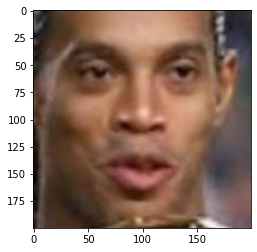

Predicted Age: 29, Actual age: 25
Predicted Sex: Male, Actual sex: Male


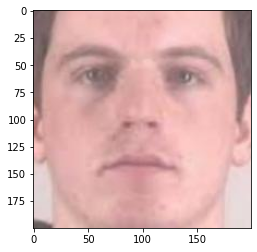

Predicted Age: 27, Actual age: 23
Predicted Sex: Male, Actual sex: Male


<Figure size 432x288 with 0 Axes>

In [511]:
# test 20 random images
correct_age = 0
correct_sex = 0
error_bound = 5
results = []
# numTest = int(len(images)*0.2)
numTest = 100
# for i in tqdm(range(numTest), ncols=100, desc="Random sampling from test-set"):
for i in range(numTest):
    age = []
    gender = []
    res = []
    
    img_index = int(np.random.uniform(0, len(images)))
#     print(f"############# Image no. {i+1} #############")
    pred_age, act_age, pred_sex, act_sex = test_image(img_index,images, genders, ages, Model, showImg=True, withLabel=True, withReturn=True)
    
    age.append(pred_age)
    age.append(act_age)
    age.append(0)
    
    for e in range(error_bound):
        if pred_age+e == act_age or pred_age-e == act_age:
#             correct_age += 1
            age[2] = 1

    gender.append(pred_sex)
    gender.append(act_sex)
    if pred_sex == act_sex:
        correct_sex += 1
        gender.append(1)
    else:
        gender.append(0)
    
    res.append(gender)
    res.append(age)
    res.append([img_index, 0, 0])
    results.append(res)
    
# print("#######################################################################")
# print(f"Accuracy: age {(correct_age/numTest)*100}% - sex {(correct_sex/numTest)*100}%")
    
    

In [512]:
results = np.array(results)
sex_p = results[:,0]
ages_p = results[:,1]
acc_age = np.around((np.sum(ages_p, axis=0)/ages_p.shape[0])[2], decimals=2)
acc_sex = np.around((np.sum(sex_p, axis=0)/sex_p.shape[0])[2], decimals=2)
(acc_sex, acc_age)

(0.95, 0.65)

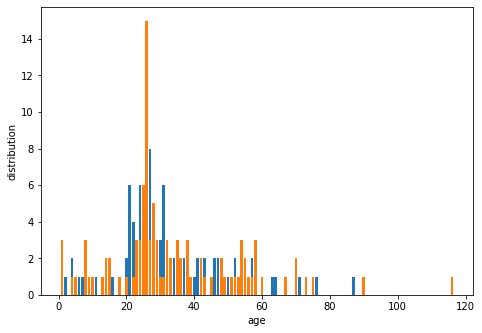

In [513]:
ages_p_val, ages_p_count = np.unique(ages_p[:,0], return_counts=True)
ages_a_val, ages_a_count = np.unique(ages_p[:,1], return_counts=True)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(ages_p_val, ages_p_count)
ax.bar(ages_a_val, ages_a_count)
plt.xlabel('age')
plt.ylabel('distribution')
plt.show()

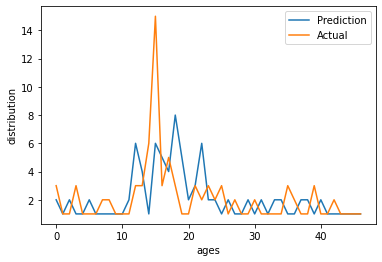

In [514]:
plt.plot(ages_p_count)
plt.plot(ages_a_count)
plt.legend(['Prediction', 'Actual'], loc='upper right')
plt.xlabel('ages')
plt.ylabel('distribution')
plt.show()

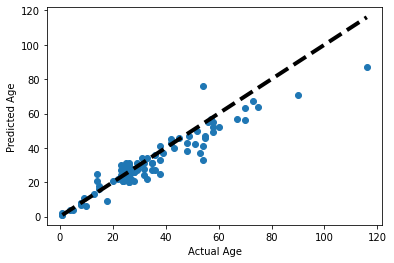

In [515]:
fig, ax = plt.subplots()
ax.scatter(ages_p[:,1], ages_p[:,0])
ax.plot([ages_p[:,1].min(),ages_p[:,1].max()], [ages_p[:,1].min(), ages_p[:,1].max()], 'k--', lw=4)
ax.set_xlabel('Actual Age')
ax.set_ylabel('Predicted Age')
plt.show()

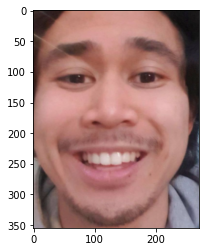

Predicted Age: 24
Predicted Sex: Male


In [49]:
import cv2 as cv
img = cv.imread("./images/Ahappy.png")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img_resized = cv.resize(img,(48,48))
plt.imshow(img)
plt.show()
test_images = [img_resized]
test_images_2 = [img_resized/255]
test_image(0, test_images, genders, ages, Model)

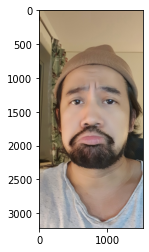

Predicted Age: 22
Predicted Sex: Male


In [51]:
img = cv.imread("./images/boboSad.jpg")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img_resized = cv.resize(img,(48,48))
plt.imshow(img)
plt.show()
test_images = [img_resized]
test_images_2 = [img_resized/255]
test_image(0, test_images, genders, ages, Model)

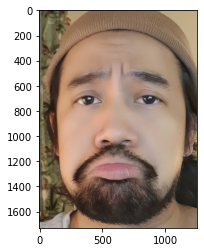

Predicted Age: 18
Predicted Sex: Male


In [54]:
img = cv.imread("./images/boboSad_crop.jpg")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img_resized = cv.resize(img,(48,48))
plt.imshow(img)
plt.show()
test_images = [img_resized]
test_images_2 = [img_resized/255]
test_image(0, test_images, genders, ages, Model)

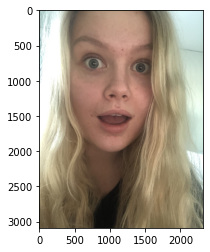

Predicted Age: 40
Predicted Sex: Male


In [53]:
img = cv.imread("./images/image0.jpg")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img_resized = cv.resize(img,(48,48))
plt.imshow(img)
plt.show()
test_images = [img_resized]
test_images_2 = [img_resized/255]
test_image(0, test_images, genders, ages, Model, withLabel=False)

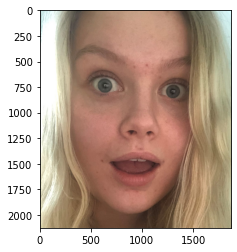

Predicted Age: 21
Predicted Sex: Female


In [52]:
img = cv.imread("./images/elsa_crop.jpg")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img_resized = cv.resize(img,(48,48))
plt.imshow(img)
plt.show()
test_images = [img_resized]
test_images_2 = [img_resized/255]
test_image(0, test_images, genders, ages, Model, withLabel=False)

### Testing with face detection model

In [5]:
# Extract faces from imaga
faces = extractFaces('./images/test.jpg', scaleFactor=1.2, minNeighbours=5)

C:\Users\cpang\D7041E_mini_project\helpers\facedetection.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  faces_return = np.array(faces_list)


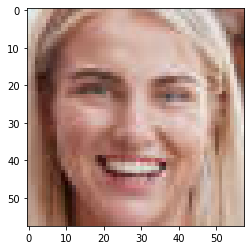

Predicted Age: 20
Predicted Sex: Female


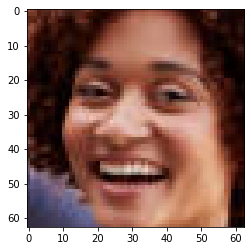

Predicted Age: 19
Predicted Sex: Female


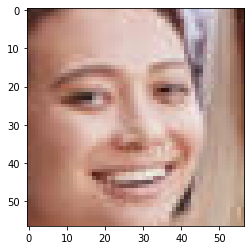

Predicted Age: 21
Predicted Sex: Female


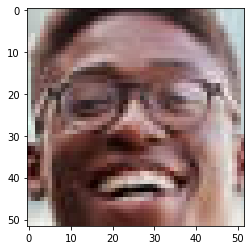

Predicted Age: 41
Predicted Sex: Female


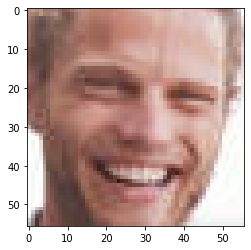

Predicted Age: 28
Predicted Sex: Male


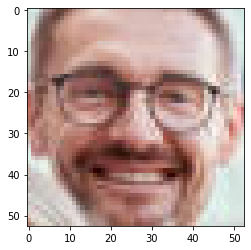

Predicted Age: 40
Predicted Sex: Male


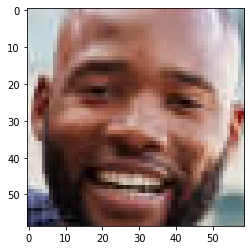

Predicted Age: 32
Predicted Sex: Male


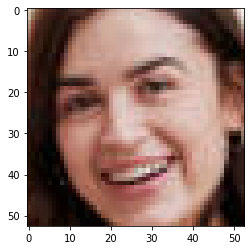

Predicted Age: 24
Predicted Sex: Female


In [8]:
for face in faces:
    # resize img
    img = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (48, 48))

    # show face
    plt.imshow(img)
    plt.show()
    
    # predict gender and age
    test_image(0, [img_resized],genders, ages, Model)